In [1]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ML model and preprocessing imports
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

# Fine-tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# Pipeline imports
from sklearn.pipeline import Pipeline, make_pipeline

# External libraries
import xgboost as xgb

# Local imports
from ML_preprocessing import prepare_data_for_ML, get_features_and_target

# Getting data

In [2]:
df = get_features_and_target("BTC/USDT", day_to_forecast=1)
X = df.drop(columns="BTC:USDT_target")
y = df["BTC:USDT_target"].copy()

X_train, X_test, y_train, y_test = prepare_data_for_ML(
    "BTC/USDT", testing_hours=3000, day_to_forecast=1
)

# Distributins after transformation 


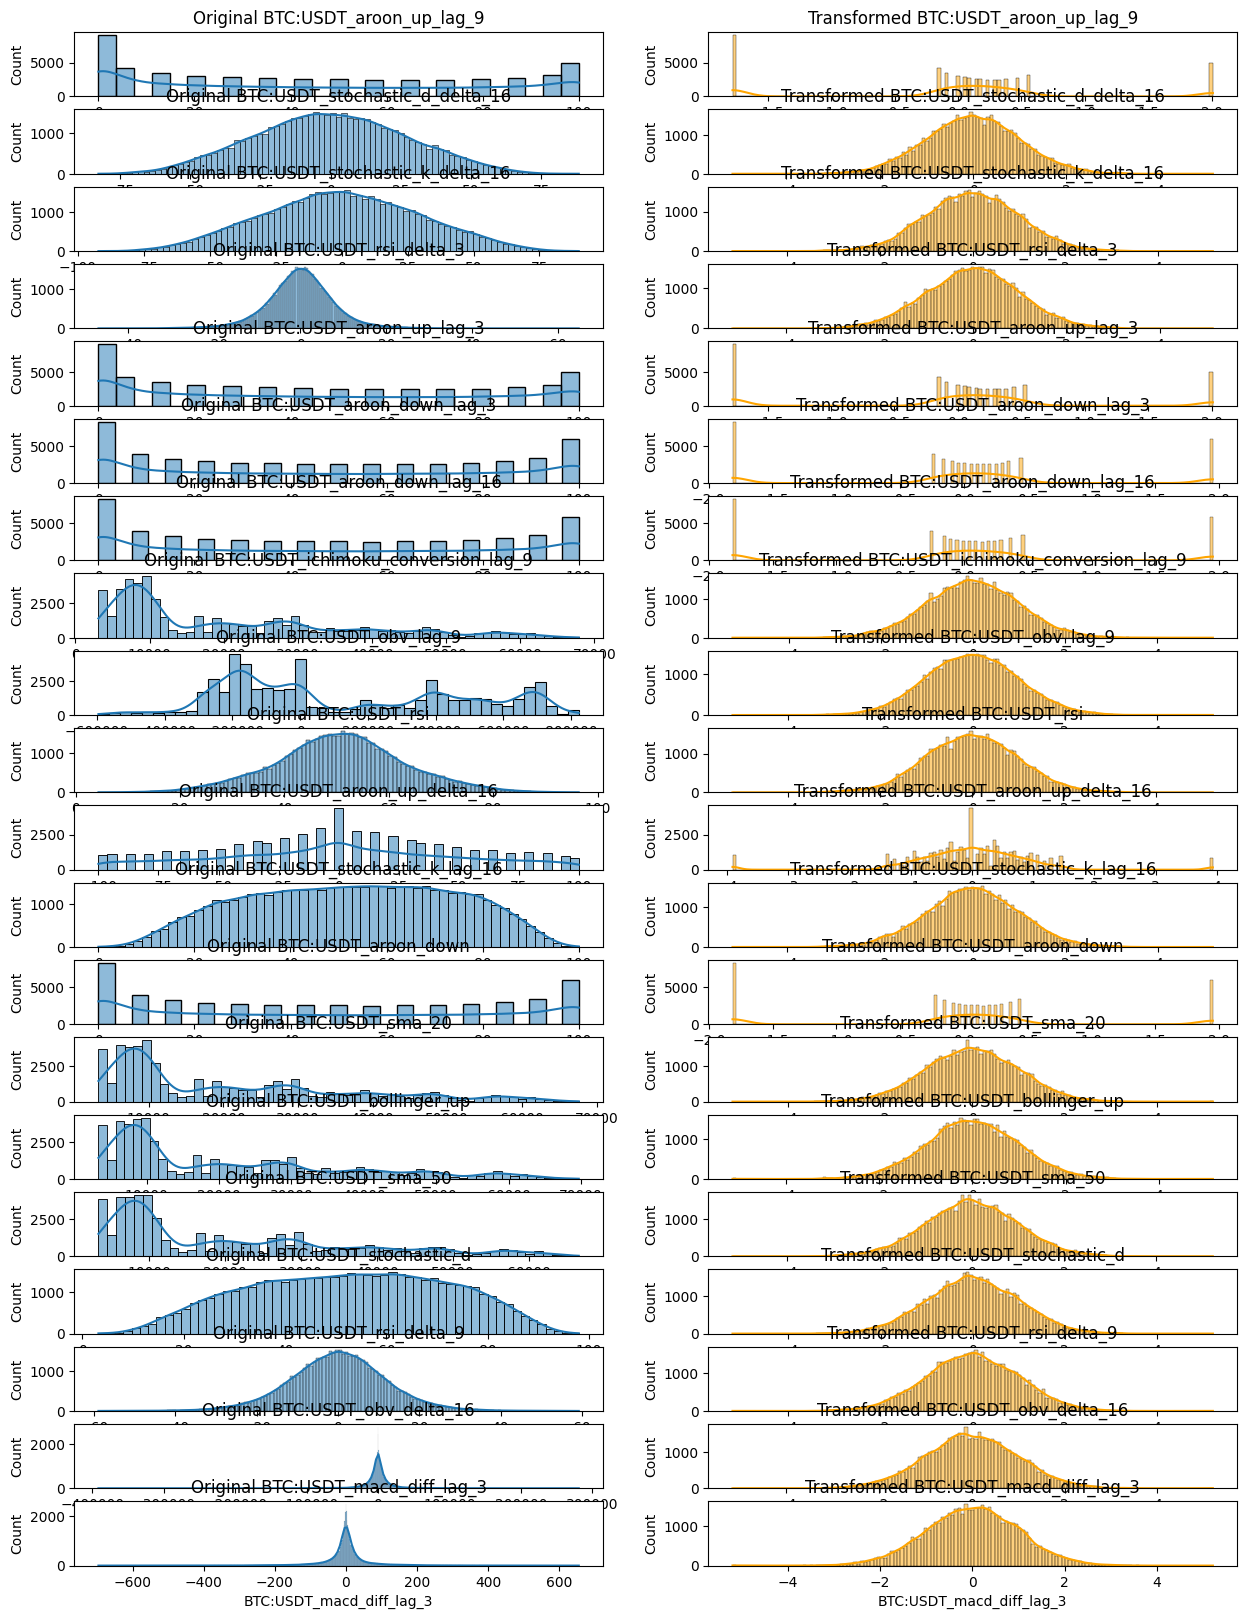

In [8]:
# Apply Quantile Transformer
transform_pipe = Pipeline(
    [
        (
            "Normilizer",
            QuantileTransformer(output_distribution="normal", random_state=99),
        ),
        ("Scaler", StandardScaler()),
    ]
)
X_transformed = transform_pipe.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed, columns=X.columns)

# Select 20 random columns (same as before)
num_cols = min(len(X.columns), 20)
random_columns = np.random.choice(X.columns, num_cols, replace=False)

# Set up the matplotlib figure (2 rows for each column: before and after)
plt.figure(figsize=(15, 2 * 20))  # Adjust the size as needed

# Plot each histogram before and after transformation
for i, col in enumerate(random_columns):
    # Original Data
    plt.subplot(2 * num_cols, 2, 2 * i + 1)  # 2*num_cols rows, 2 columns per row
    sns.histplot(X[col], kde=True)
    plt.title(f"Original {col}")
    # plt.tight_layout()

    # Transformed Data
    plt.subplot(2 * num_cols, 2, 2 * i + 2)
    sns.histplot(X_transformed[col], kde=True, color="orange")
    plt.title(f"Transformed {col}")
    # plt.tight_layout()

plt.show()

# Test of feature selection

In [ ]:
# Example using RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
sfm = SelectFromModel(model)

# Assume X and y are your training data and labels
sfm.fit(X, y)

# To see the features selected
selected_features = sfm.get_support()
print("Selected features:", selected_features)

# To get the names of the selected features if you have a DataFrame
selected_feature_names = X.columns[selected_features]
print("Selected feature names:", selected_feature_names)

"""
Selected features: [ True  True  True  True False  True  True  True  True  True  True False
 False False False False False  True False False False False False False
 False False False False False False False False  True  True  True False
 False False False False False False  True False False False False False
  True  True  True False False False False False False  True  True False
 False False False]
Selected feature names: Index(['BTC:USDT_sma_9', 'BTC:USDT_sma_20', 'BTC:USDT_sma_50',
       'BTC:USDT_sma_200', 'BTC:USDT_bollinger_up', 'BTC:USDT_bollinger_down',
       'BTC:USDT_adx', 'BTC:USDT_macd_diff', 'BTC:USDT_obv',
       'BTC:USDT_ichimoku_conversion', 'BTC:USDT_obv_lag_3',
       'BTC:USDT_macd_diff_lag_9', 'BTC:USDT_obv_lag_9',
       'BTC:USDT_ichimoku_conversion_lag_9',
       'BTC:USDT_ichimoku_conversion_delta_9', 'BTC:USDT_macd_diff_lag_16',
       'BTC:USDT_obv_lag_16', 'BTC:USDT_ichimoku_conversion_lag_16',
       'BTC:USDT_obv_delta_16', 'BTC:USDT_ichimoku_conversion_delta_16'],
      dtype='object')"""

# Pipeline

In [3]:
# Preprocessing pipeline
preprocessing = make_pipeline(
    QuantileTransformer(output_distribution="normal", random_state=99),
    StandardScaler(),
    SelectFromModel(RandomForestRegressor(random_state=99)),
)

# Define the pipelines for each model
pipelines = {
    "Random_Forest": Pipeline(
        [
            ("prep", preprocessing),
            ("model", RandomForestRegressor(random_state=99)),
        ]  # Winner
    ),
    "Gradient_Boosting": Pipeline(
        [("prep", preprocessing), ("model", GradientBoostingRegressor(random_state=99))]
    ),
    "Linear_Regression": Pipeline(
        [("prep", preprocessing), ("model", LinearRegression())]
    ),
    "K-Nearest_Neighbors": Pipeline(
        [("prep", preprocessing), ("model", KNeighborsRegressor())]
    ),
    "XGBoost": Pipeline(
        [
            ("prep", preprocessing),
            ("model", xgb.XGBRegressor(random_state=99)),
        ]  # Second place
    ),
    "SVR": Pipeline([("prep", preprocessing), ("model", SVR())]),
    "ElasticNet": Pipeline([("prep", preprocessing), ("model", ElasticNet())]),
}

# Testing of default models

In [15]:
scores = {}
for name, pipeline in pipelines.items():
    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=-1
    )
    scores[name] = -score  # Negate to get positive MSE values back

scores_df = pd.DataFrame(scores)

scores_df.to_csv("models_results.csv")

scores_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Random_Forest,Gradient_Boosting,Linear_Regression,K-Nearest_Neighbors,XGBoost,SVR,ElasticNet
0,0.000431,0.001549,0.001683,0.000983,0.000699,0.002110,0.001704
1,0.000310,0.001447,0.001596,0.000850,0.000633,0.001943,0.001620
2,0.000393,0.001490,0.001626,0.000925,0.000736,0.002061,0.001651
3,0.000341,0.001452,0.001590,0.000821,0.000660,0.001946,0.001601
4,0.000337,0.001365,0.001512,0.000850,0.000630,0.001865,0.001531


In [16]:
scores_df.mean()

Random_Forest          0.000362
Gradient_Boosting      0.001461
Linear_Regression      0.001601
K-Nearest_Neighbors    0.000886
XGBoost                0.000671
SVR                    0.001985
ElasticNet             0.001621
dtype: float64

# Fine-tuning


In [10]:
preprocessing = make_pipeline(
    QuantileTransformer(output_distribution="normal", random_state=99),
    StandardScaler(),
    SelectFromModel(RandomForestRegressor(random_state=99)),
)

random_forest = Pipeline(
    [
        ("prep", preprocessing),
        ("model", RandomForestRegressor(random_state=99)),
    ]  # Winner
)

xgboost = Pipeline(
    [
        ("prep", preprocessing),
        ("model", xgb.XGBRegressor(random_state=99)),
    ]  # Second place
)

In [11]:
"""
TO DO 

1. Tests on X_test (with all metrics -
mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score

2. Grid or Random with best model

"""
random_forest.fit(X_train, y_train)

predictions = random_forest.predict(X_test)

# Not fine-tuned RF metrics

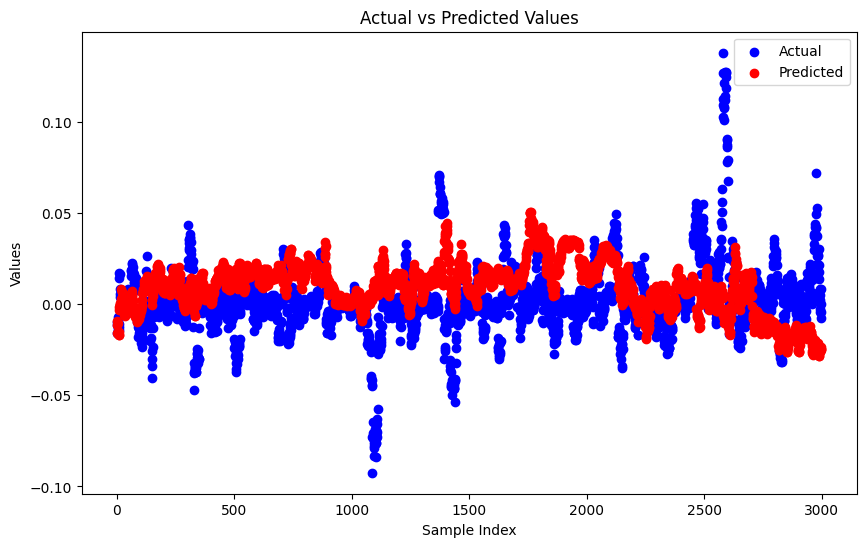

Mean Absolute Error: 0.019115084626099687
Mean Absolute Percentage Error: 39.48405316687854
Mean Squared Error: 0.0006378236556704867
R2 Score: -0.7616616827679181


In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue")
plt.scatter(range(len(predictions)), predictions, label="Predicted", color="red")
plt.title("Actual vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.legend()
plt.show()

test1 = mean_absolute_error(y_test, predictions)
test2 = mean_absolute_percentage_error(y_test, predictions)
test3 = mean_squared_error(y_test, predictions)
test4 = r2_score(y_test, predictions)

# Printing the errors
print("Mean Absolute Error:", test1)
print("Mean Absolute Percentage Error:", test2)
print("Mean Squared Error:", test3)
print("R2 Score:", test4)

# Create a DataFrame with actual and predicted values
df = pd.DataFrame({"True": y_test, "Preds": predictions})

# Save the DataFrame to a CSV file
# df.to_csv("check_RF_default.csv", index=False)

# Not fine-tuned XGboost metrics ( Shit )

In [12]:
xgboost.fit(X_train, y_train)

predictions = xgboost.predict(X_test)

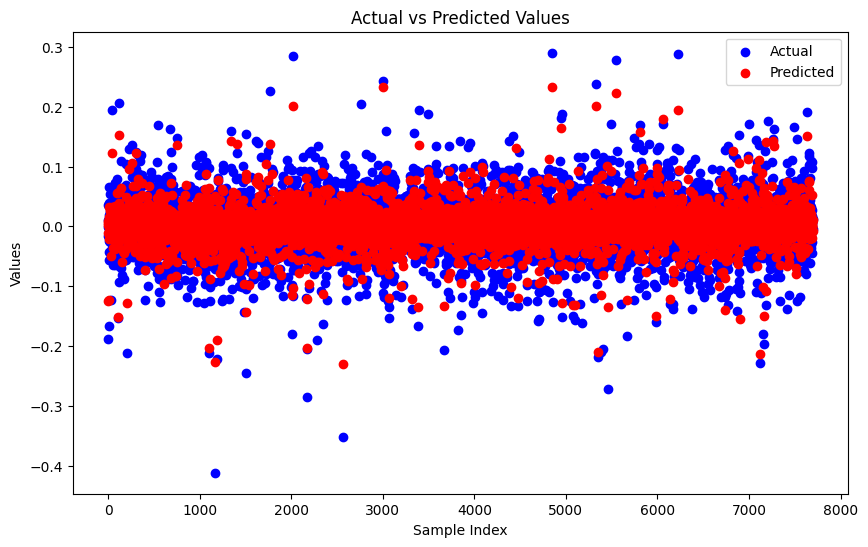

Mean Absolute Error: 0.017741797671143134
Mean Absolute Percentage Error: 4.7907563545111636
Mean Squared Error: 0.0006199826090340103
R2 Score: 0.6292345495729115


In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue")
plt.scatter(range(len(predictions)), predictions, label="Predicted", color="red")
plt.title("Actual vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.legend()
plt.show()

test1 = mean_absolute_error(y_test, predictions)
test2 = mean_absolute_percentage_error(y_test, predictions)
test3 = mean_squared_error(y_test, predictions)
test4 = r2_score(y_test, predictions)

# Printing the errors
print("Mean Absolute Error:", test1)
print("Mean Absolute Percentage Error:", test2)
print("Mean Squared Error:", test3)
print("R2 Score:", test4)

# Create a DataFrame with actual and predicted values
df = pd.DataFrame({"True": y_test, "Preds": predictions})

# Save the DataFrame to a CSV file
df.to_csv("check_xgboost_default.csv", index=False)

# Fine-tuning RandomForest

# BayesOpt ( does not work with numpy 1.2...)

In [ ]:
search_space = {
    "model__n_estimators": Integer(100, 500),
    "model__min_samples_split": Integer(2, 10),
    "model__min_samples_leaf": Integer(1, 5),
    "model__max_features": Categorical(["auto", "sqrt", "log2"]),
    "model__bootstrap": Categorical([True, False]),
}
# Create a RandomizedSearchCV object
opt = BayesSearchCV(
    estimator=random_forest,
    search_spaces=search_space,
    n_iter=50,  # Number of iterations
    cv=4,  # Cross-validation splitting strategy
    n_jobs=-1,  # Using all processors
    random_state=0,
    verbose=2,
)


# Fit the model on the training data
opt.fit(X_train, y_train)

# Get the best parameters and the best model

bets_params = opt.best_params_
cv_results_df = pd.DataFrame(opt.cv_results_)

# RandomSeach 

In [ ]:
param_grid = {
    "model__n_estimators": [200, 300, 400],
    "model__max_depth": [None, 20],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 4],
    "model__max_features": ["auto", "sqrt", "log2"],
    "model__bootstrap": [True, False],
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled. Adjust as needed.
    cv=4,
    verbose=2,
    n_jobs=-1,  # Using all processors
    random_state=99,  # Optional, for reproducible results
)

# Fit the model on the training data
random_search.fit(X, y)

# Get the best parameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

best_score = random_search.best_score_